Titanic dataset download and overview

In [ ]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental import preprocessing

In [ ]:
pd.set_option('display.max_rows', 10000)

Overview

In [ ]:
TRAIN_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/train.csv"
TEST_DATA_URL = "https://storage.googleapis.com/tf-datasets/titanic/eval.csv"

train_file_path = tf.keras.utils.get_file("train.csv", TRAIN_DATA_URL)
test_file_path = tf.keras.utils.get_file("eval.csv", TEST_DATA_URL)

13049/13049 [==============================] - 0s 0us/step


In [ ]:
!head {train_file_path}

survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.25,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
1,female,26.0,0,0,7.925,Third,unknown,Southampton,y
1,female,35.0,1,0,53.1,First,C,Southampton,n
0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y
0,male,2.0,3,1,21.075,Third,unknown,Southampton,n
1,female,27.0,0,2,11.1333,Third,unknown,Southampton,n
1,female,14.0,1,0,30.0708,Second,unknown,Cherbourg,n
1,female,4.0,1,1,16.7,Third,G,Southampton,n


Data preparation and exploratory analysis




Split the dataframe into train, validation and test

In [ ]:
train = pd.read_csv(train_file_path)
test = pd.read_csv(test_file_path)

In [ ]:
test, val = train_test_split(test, test_size=0.5)

In [ ]:
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

627 train examples
132 validation examples
132 test examples


<Axes: >

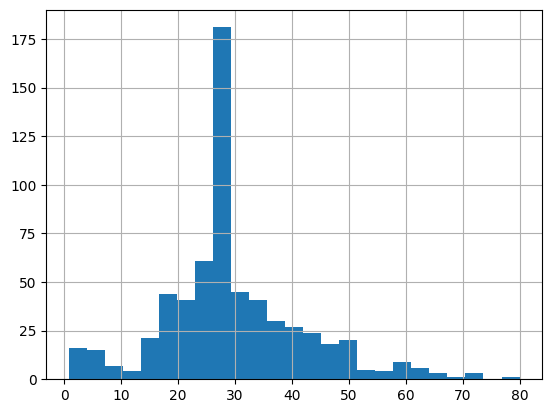

In [ ]:
train.age.hist(bins=25)

<Axes: >

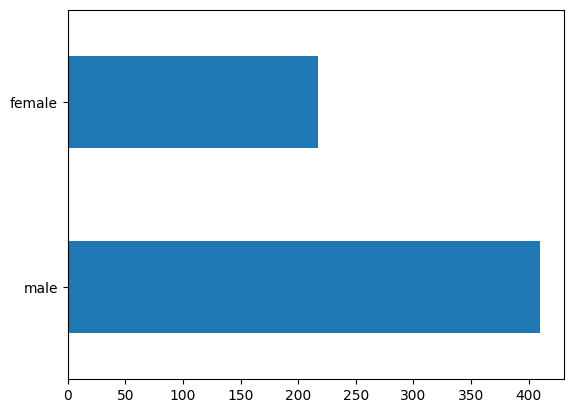

In [ ]:
train.sex.value_counts().plot(kind='barh')

<Axes: >

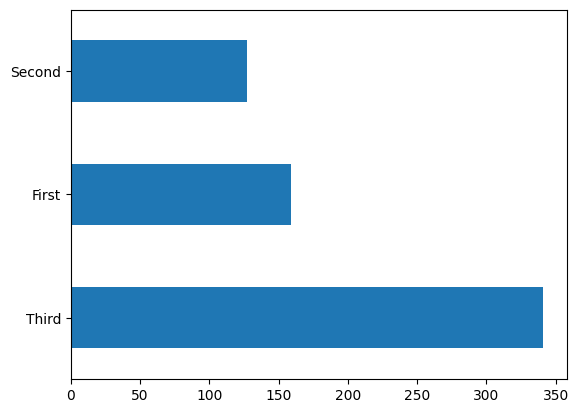

In [ ]:
train['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survived')

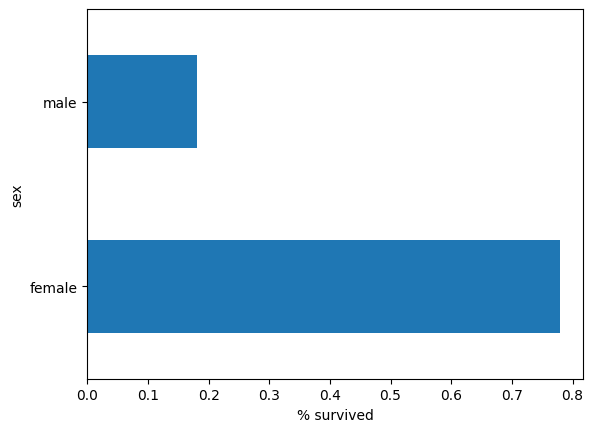

In [ ]:
train.groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survived')

In [ ]:
train[(train.age < 18) & (train['class'] == 'First')]

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
221,1,female,17.0,1,0,108.9000,First,C,Cherbourg,n
315,1,female,14.0,1,2,120.0000,First,B,Southampton,n
395,1,male,17.0,0,2,110.8833,First,C,Cherbourg,n
489,1,female,15.0,0,1,211.3375,First,B,Southampton,n
547,1,female,17.0,1,0,57.0000,First,B,Southampton,n
565,1,male,11.0,1,2,120.0000,First,B,Southampton,n
601,1,female,16.0,0,1,39.4000,First,D,Southampton,n


tf.data API

In [ ]:
help(tf.data.Dataset.from_tensor_slices)

Help on function from_tensor_slices in module tensorflow.python.data.ops.dataset_ops:

from_tensor_slices(tensors, name=None)
    Creates a `Dataset` whose elements are slices of the given tensors.
    
    The given tensors are sliced along their first dimension. This operation
    preserves the structure of the input tensors, removing the first dimension
    of each tensor and using it as the dataset dimension. All input tensors
    must have the same size in their first dimensions.
    
    >>> # Slicing a 1D tensor produces scalar tensor elements.
    >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
    >>> list(dataset.as_numpy_iterator())
    [1, 2, 3]
    
    >>> # Slicing a 2D tensor produces 1D tensor elements.
    >>> dataset = tf.data.Dataset.from_tensor_slices([[1, 2], [3, 4]])
    >>> list(dataset.as_numpy_iterator())
    [array([1, 2], dtype=int32), array([3, 4], dtype=int32)]
    
    >>> # Slicing a tuple of 1D tensors produces tuple elements containing
    

In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=3):
  '''Creates a tf.data dataset from a Pandas Dataframe'''
  dataframe = dataframe.copy()
  labels = dataframe.pop('survived')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  #We'll also want to process this a batch-size at a time, so we can use the batch method.  
  ds = ds.batch(batch_size)
  #Prefetching allows us to optimise fetching of data and training
  ds = ds.prefetch(batch_size)
  return ds

In [ ]:
train_ds = df_to_dataset(train)
train_ds

<_PrefetchDataset element_spec=({'sex': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'age': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'n_siblings_spouses': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'parch': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 'fare': TensorSpec(shape=(None,), dtype=tf.float64, name=None), 'class': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'deck': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'embark_town': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'alone': TensorSpec(shape=(None,), dtype=tf.string, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
[(train_features, label_batch)] = train_ds.take(1)
label_batch

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([1, 1, 0])>

In [ ]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of ages:', train_features['age'])
print('A batch of labels:', label_batch )

Every feature: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']
A batch of ages: tf.Tensor([42.  19.  40.5], shape=(3,), dtype=float64)
A batch of labels: tf.Tensor([0 0 0], shape=(3,), dtype=int64)


Feature engineering

Numeric columns

In [ ]:
train.describe()

,survived,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000,627.000000
mean,0.387560,29.631308,0.545455,0.379585,34.385399
std,0.487582,12.511818,1.151090,0.792999,54.597730
min,0.000000,0.750000,0.000000,0.000000,0.000000
25%,0.000000,23.000000,0.000000,0.000000,7.895800
50%,0.000000,28.000000,0.000000,0.000000,15.045800
75%,1.000000,35.000000,1.000000,0.000000,31.387500
max,1.000000,80.000000,8.000000,5.000000,512.329200


In [ ]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization(axis=None)

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # A pre-processing / non-traininable layer. 
  normalizer.adapt(feature_ds)

  return normalizer

In [ ]:
age_column = train_features['age']
age_column

<tf.Tensor: shape=(3,), dtype=float64, numpy=array([42. , 19. , 40.5])>

In [ ]:
numeric_layer = get_normalization_layer('age', train_ds)
numeric_layer(age_column)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.9893505 , -0.85037977,  0.8693681 ], dtype=float32)>

Categorical columns

In [ ]:
train.embark_town.unique()

array(['Southampton', 'Cherbourg', 'Queenstown', 'unknown'], dtype=object)

In [ ]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_tokens=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply one-hot encoding to our indices and return this feature
  return lambda feature: encoder(index(feature))

In [ ]:
index = preprocessing.StringLookup(max_tokens=None)
feature_ds = train_ds.map(lambda x, y: x['embark_town'])
index.adapt(feature_ds)

print(f'vocabulary: {index.get_vocabulary()}')
print(f'vocabulary size: {index.vocabulary_size()}')

vocabulary: ['[UNK]', 'Southampton', 'Cherbourg', 'Queenstown', 'unknown']
vocabulary size: 5


In [ ]:
index.oov_token

'[UNK]'

In [ ]:
embark_town_column = train_features['embark_town']
embark_town_column

<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'Southampton', b'Southampton', b'Queenstown'], dtype=object)>

In [ ]:
categorical_layer = get_category_encoding_layer('embark_town', train_ds, 'string')
categorical_layer(embark_town_column)

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 0., 1., 0.], dtype=float32)>

Creating a pipeline

In [ ]:
batch_size = 64
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [ ]:
all_inputs = []
encoded_features = []

# Numeric features.
numeric_columns = ['age', 'n_siblings_spouses', 'parch', 'fare']
for column_name in numeric_columns:
  numeric_column = tf.keras.Input(shape=(1,), name=column_name)
  normalization_layer = get_normalization_layer(column_name, train_ds)
  encoded_numeric_column = normalization_layer(numeric_column)
  all_inputs.append(numeric_column)
  encoded_features.append(encoded_numeric_column)

# Categorical features encoded as string.
categorical_columns = ['sex', 'class', 'embark_town', 'deck', 'alone']
for column_name in categorical_columns:
  categorical_column = tf.keras.Input(shape=(1,), name=column_name, dtype='string')
  encoding_layer = get_category_encoding_layer(column_name, train_ds, dtype='string', max_tokens=5)
  encoded_categorical_column = encoding_layer(categorical_column)
  all_inputs.append(categorical_column)
  encoded_features.append(encoded_categorical_column)

In [ ]:
all_inputs

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'n_siblings_spouses')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'parch')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'fare')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'sex')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'class')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'embark_town')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'deck')>,
 <KerasTensor: shape=(None, 1) dtype=string (created by layer 'alone')>]

In [ ]:
encoded_features

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_1')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_2')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_3')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_4')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_1')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_2')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_3')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_4')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_5')>]

Train and evaluate the model


In [ ]:
#compile
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(128, activation="relu")(all_features)
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

Train and evaluate model

In [ ]:
model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
10/10 [==============================] - 2s 49ms/step - loss: 0.6471 - accuracy: 0.6220 - val_loss: 0.5553 - val_accuracy: 0.6818
Epoch 2/10
10/10 [==============================] - 0s 4ms/step - loss: 0.5432 - accuracy: 0.6730 - val_loss: 0.4776 - val_accuracy: 0.7424
Epoch 3/10
10/10 [==============================] - 0s 4ms/step - loss: 0.4872 - accuracy: 0.7384 - val_loss: 0.4378 - val_accuracy: 0.7879
Epoch 4/10
10/10 [==============================] - 0s 5ms/step - loss: 0.4439 - accuracy: 0.7959 - val_loss: 0.4026 - val_accuracy: 0.8409
Epoch 5/10
10/10 [==============================] - 0s 4ms/step - loss: 0.4268 - accuracy: 0.8070 - val_loss: 0.3895 - val_accuracy: 0.8636
Epoch 6/10
10/10 [==============================] - 0s 4ms/step - loss: 0.4125 - accuracy: 0.8246 - val_loss: 0.3796 - val_accuracy: 0.8561
Epoch 7/10
10/10 [==============================] - 0s 4ms/step - loss: 0.4049 - accuracy: 0.8357 - val_loss: 0.3685 - val_accuracy: 0.8712
Epoch 8/10
10/10 [=

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

3/3 [==============================] - 0s 6ms/step - loss: 0.4833 - accuracy: 0.7803
Accuracy 0.7803030014038086


In [ ]:
model.save('classifier')